In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Pre-Processing

In [2]:
df = pd.read_csv('./data/sql_injection_raw.csv',encoding='utf-16')

In [3]:
df = df.dropna()

In [4]:
# Get unique values existing in the label column to check if need to clean that

df['Label'].value_counts()

0    22304
1    11453
Name: Label, dtype: int64

In [5]:
df.Label.dtype #making sure that Label is int

dtype('int64')

In [6]:
df['Sentence']

1                            " or pg_sleep ( __TIME__ ) --
2        create user name identified by pass123 tempora...
3                                                      %29
4        ' AND 1 = utl_inaddr.get_host_address  (  (  S...
5         select * from users where id = '1' or @ @1 = ...
                               ...                        
33756                                               syrett
33757                                     arrechea bellveh
33758                                                 1664
33759                                             almaluez
33760                                            f6lo40r06
Name: Sentence, Length: 33757, dtype: object

In [7]:
df.rename(columns={'Sentence': 'query', 'Label': 'label'}, inplace=True)

In [8]:
df.head()

query  label
1                      " or pg_sleep ( __TIME__ ) --      1
2  create user name identified by pass123 tempora...      1
3                                                %29      1
4  ' AND 1 = utl_inaddr.get_host_address  (  (  S...      1
5   select * from users where id = '1' or @ @1 = ...      1

In [9]:
df.describe()

label
count  33757.000000
mean       0.339278
std        0.473471
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [10]:
# Separate the DataFrame into two based on the label
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

# Randomly sample 500 rows from each
df_label_1_sampled = df_label_1.sample(n=500, random_state=1)
df_label_0_sampled = df_label_0.sample(n=500, random_state=1)

# Combine the samples into one DataFrame
df_sampled = pd.concat([df_label_1_sampled, df_label_0_sampled])

# Shuffle the combined DataFrame
df = df_sampled.sample(frac=1, random_state=1).reset_index(drop=True)

In [11]:
df.describe()

label
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000

In [12]:
df['label'].value_counts()

0    500
1    500
Name: label, dtype: int64

In [13]:
df_injection = df

In [14]:
df_processing_time = pd.read_csv('./data/queries_with_processing_times.csv')

In [15]:
df_processing_time.isna().sum()

query                0
processing_time    203
dtype: int64

In [16]:
df_processing_time = df_processing_time.dropna()

In [17]:
df_processing_time.isna().sum()

query              0
processing_time    0
dtype: int64

In [18]:
df_processing_time['query'] = df_processing_time['query'].str.strip()

In [19]:
df_processing_time.head()

query  processing_time
0          SELECT * FROM Products WHERE Price > 500;         1.666016
1  SELECT * FROM Customers WHERE LastName LIKE 'S%';         0.591064
2  SELECT OrderID, CustomerID FROM Orders WHERE O...         0.555908
3  SELECT ProductName, Stock FROM Products WHERE ...         0.737061
4  SELECT COUNT(*) FROM Orders WHERE TotalAmount ...         0.500000

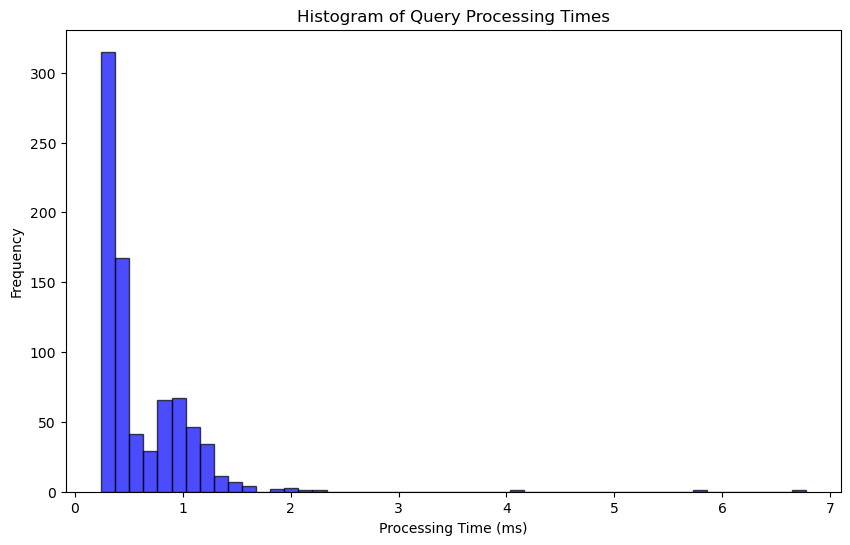

In [20]:
# Create a histogram of processing times
plt.figure(figsize=(10, 6))
plt.hist(df_processing_time['processing_time'], bins=50, color='blue', alpha=0.7, edgecolor='black')

# Add title and labels
plt.title('Histogram of Query Processing Times')
plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [21]:
#data doesnt follow gaussian distriubution 
#so we will use We'll set the threshold based on the 95th percentile of the data
#Top 5% of the processing times will be considered as anomalies.

threshold = df_processing_time['processing_time'].quantile(0.95)

In [22]:
# Label queries as anomalies if their processing time is above the threshold
df_processing_time['label'] = df_processing_time['processing_time'].apply(lambda x: 1 if x > threshold else 0)

In [23]:
df_processing_time.head()

query  processing_time  label
0          SELECT * FROM Products WHERE Price > 500;         1.666016      1
1  SELECT * FROM Customers WHERE LastName LIKE 'S%';         0.591064      0
2  SELECT OrderID, CustomerID FROM Orders WHERE O...         0.555908      0
3  SELECT ProductName, Stock FROM Products WHERE ...         0.737061      0
4  SELECT COUNT(*) FROM Orders WHERE TotalAmount ...         0.500000      0

In [24]:
df_processing_time['label'].value_counts()

0    757
1     40
Name: label, dtype: int64

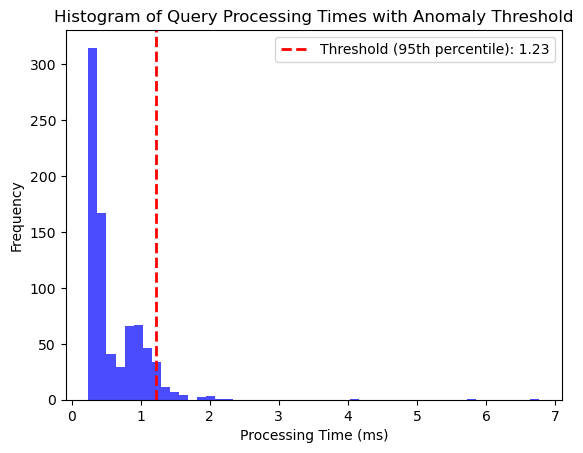

In [25]:
# Plot the histogram of processing times
plt.hist(df_processing_time['processing_time'], bins=50, color='blue', alpha=0.7)

# Add a vertical line at the threshold
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold (95th percentile): {threshold:.2f}')

# Add labels and title
plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Query Processing Times with Anomaly Threshold')
plt.legend()

# Show the plot
plt.show()

In [26]:
df_processing_time = df_processing_time.drop(columns=['processing_time'])

In [27]:
df_processing_time.head()

query  label
0          SELECT * FROM Products WHERE Price > 500;      1
1  SELECT * FROM Customers WHERE LastName LIKE 'S%';      0
2  SELECT OrderID, CustomerID FROM Orders WHERE O...      0
3  SELECT ProductName, Stock FROM Products WHERE ...      0
4  SELECT COUNT(*) FROM Orders WHERE TotalAmount ...      0

In [28]:
merged_df = pd.concat([df_injection, df_processing_time], ignore_index=True)

In [29]:
merged_df.head()

query  label
0                    av. jose ferrandez cruz 182, 8b      0
1                                          19283115f      0
2                      1',iif ( 9496 = 4153,1,1/0 )       1
3  1  )  )   )  or 6979 = like ( 'abcdefg',upper ...      1
4  1 )  where 9821 = 9821 or  ( select * from  ( ...      1

In [30]:
merged_df.describe()

label
count  1797.000000
mean      0.300501
std       0.458603
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

# Feature Engineering

In [32]:
# Split the data into training and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['label'])

# Perform Count Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['query'])
X_test = vectorizer.transform(test_df['query'])

# Convert the sparse matrix to a dense matrix to make it easier to analyze, and train on machine learning models. 
# Then convert this to a DataFrame
X_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

In [33]:
X_train_df

000  00863764e  01  01212  0156765529256872  04146926a  04492457m  \
0       0          0   0      0                 0          0          0   
1       0          0   0      0                 0          0          0   
2       0          0   0      0                 0          0          0   
3       0          0   0      0                 0          0          0   
4       0          0   0      0                 0          0          0   
...   ...        ...  ..    ...               ...        ...        ...   
1432    0          0   0      0                 0          0          0   
1433    0          0   0      0                 0          0          0   
1434    0          0   0      0                 0          0          0   
1435    0          0   0      0                 0          0          0   
1436    0          0   0      0                 0          0          0   

      04858  05  05141  ...  zone  zool7ic1  zoqo  zpvn  ztmd  zurera  zw  \
0         0   0      0  ...     0         0     0     0     0       0   0   
1         0   0      0  ...     0         0     0     0     0       0   0   
2         0   0      0  ...     0         0     0     0     0       0   0   
3         0   0      0  ...     0         0     0     0     0       0   0   
4         0   0      0  ...     0         0     0     0     0       0   0   
...     ...  ..    ...  ...   ...       ...   ...   ...   ...     ...  ..   
1432      0   0      0  ...     0         0     0     0     0       0   0   
1433      0   0      0  ...     0         0     0     0     0       0   0   
1434      0   0      0  ...     0         0     0     0     0       0   0   
1435      0   0      0  ...     0         0     0     0     0       0   0   
1436      0   0      0  ...     0         0     0     0     0       0   0   

      zweig  zwi  zxos  
0         0    0     0  
1         0    0     0  
2         0    0     0  
3         0    0     0  
4         0    0     0  
...     ...  ...   ...  
1432      0    0     0  
1433      0    0     0  
1434      0    0     0  
1435      0    0     0  
1436      0    0     0  

[1437 rows x 2006 columns]

# Base Models

### Isolation Forest

In [371]:
# Function to evaluate the model
def evaluate_model(contamination_value):
    iso_forest = IsolationForest(contamination=contamination_value, random_state=42)
    iso_forest.fit(X_train_df)
    y_pred = iso_forest.predict(X_test_df)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(f"Contamination: {contamination_value}")
    print(classification_report(test_df['label'], y_pred))
    print(confusion_matrix(test_df['label'], y_pred))
    print("\n")

# Test different contamination values
for contamination in [0.1, 0.15, 0.2, 0.25]:
    evaluate_model(contamination)

Contamination: 0.1
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       252
           1       0.72      0.21      0.33       108

    accuracy                           0.74       360
   macro avg       0.73      0.59      0.58       360
weighted avg       0.73      0.74      0.69       360

[[243   9]
 [ 85  23]]


Contamination: 0.15
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       252
           1       0.66      0.25      0.36       108

    accuracy                           0.74       360
   macro avg       0.70      0.60      0.60       360
weighted avg       0.72      0.74      0.69       360

[[238  14]
 [ 81  27]]


Contamination: 0.2
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       252
           1       0.55      0.29      0.38       108

    accuracy                           0.72       360
   macro avg       0

In [38]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_df, train_df['label'])

y_pred = svm_model.predict(X_test_df)

print("SVM Model Performance")
print(classification_report(test_df['label'], y_pred))
print(confusion_matrix(test_df['label'], y_pred))


SVM Model Performance
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       252
           1       0.99      0.90      0.94       108

    accuracy                           0.97       360
   macro avg       0.97      0.95      0.96       360
weighted avg       0.97      0.97      0.97       360

[[251   1]
 [ 11  97]]


In [39]:
class SVDD_Network(nn.Module):
    def __init__(self, input_dim, rep_dim):
        super(SVDD_Network, self).__init__()
        self.rep_dim = rep_dim
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, rep_dim)
        )

    def forward(self, x):
        return self.network(x)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.int64)

input_dim = X_train_df.shape[1]
rep_dim = 32  
model = SVDD_Network(input_dim, rep_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

with torch.no_grad():
    center = model(X_train_tensor).mean(dim=0)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, center.expand_as(outputs))
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    distances = torch.sum((outputs - center) ** 2, dim=1).sqrt()
    threshold = torch.quantile(distances, 0.95).item()  # Use the 95th percentile as the threshold
    y_pred = (distances > threshold).int()

print("Deep SVDD Model Performance")
print(classification_report(y_test_tensor, y_pred))
print(confusion_matrix(y_test_tensor, y_pred))


Epoch [1/10], Loss: 0.0071
Epoch [2/10], Loss: 0.0032
Epoch [3/10], Loss: 0.0020
Epoch [4/10], Loss: 0.0015
Epoch [5/10], Loss: 0.0012
Epoch [6/10], Loss: 0.0010
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0007
Epoch [9/10], Loss: 0.0007
Epoch [10/10], Loss: 0.0006
Deep SVDD Model Performance
              precision    recall  f1-score   support

           0       0.70      0.95      0.81       252
           1       0.33      0.06      0.10       108

    accuracy                           0.68       360
   macro avg       0.52      0.50      0.45       360
weighted avg       0.59      0.68      0.59       360

[[240  12]
 [102   6]]


In [372]:
# we'll choose 0.25 as contamination value as we prefer catching more anomalies at the risk of some false alarms
# We cannot let a anomaly go through

### Variational Autoencoder

### Deep SVDD

### UDAD

# Ensemble

# Visualizing Results through tables and plots